In [3]:
# this is the cuda version of the stage2_1.ipynb
# we will use the cuda to accelerate the calculation of the temperature distribution

In [4]:
import ExponentialDecayModel as EDM
import InChipModel as ICM
import torch
import pandas
import utilities
import numpy as np
import math
import temperature_calculator as temp_cal
import interconnect_calculator as inter_cal
import random
import copy
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor


In [5]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [6]:
import time

In [7]:
# At the beginning of the file
DEVICE = 'cpu' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


In [8]:
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")


In [9]:
# overlap constraints

def is_2_chip_overlapping_cuda(chip1, chip2, min_edge_dist:float=0.2): 
    """
    Check if two chiplets are overlapping.
    input: 
        chip1: the first chiplet
        chip2: the second chiplet
        min_edge_dist: the minimum edge distance between two chiplets
    output: 
        True: if two chiplets are overlapping
        False: if two chiplets are not overlapping
    """
    # x1, y1 = chip1[0], chip1[1]
    # w1, h1 = chip1[2], chip1[3]
    # x2, y2 = chip2[0], chip2[1]
    # w2, h2 = chip2[2], chip2[3]

    x1, y1, w1, h1 = \
        chip1[0].item(), chip1[1].item(), chip1[2].item(), chip1[3].item()
    try: 
        x2, y2, w2, h2 = \
            chip2[0].item(), chip2[1].item(), chip2[2].item(), chip2[3].item()
    except: 
        print(chip2)

    no_overlap = \
        (x1 + w1 + min_edge_dist <= x2 or \
            x2 + w2 + min_edge_dist <= x1) or \
        (y1 + h1 + min_edge_dist <= y2 or \
            y2 + h2 + min_edge_dist <= y1)
      
    
    return not no_overlap

def check_overlap_within_layout_cuda(layout):
    """
    Check if there are overlapping chiplets within the layout.
    input: 
        layout: the layout of the chiplets
        chiplets: the chiplets
    output: 
        True: if there are overlapping chiplets
        False: if there are no overlapping chiplets
    """

    # Convert to tensor if not already
    if not torch.is_tensor(layout):
        layout = torch.tensor(layout, device=DEVICE)
    
    n = len(layout)
    # Create tensors for all pairs of chiplets
    i_indices, j_indices = torch.triu_indices(n, n, offset=1)
    
    # Vectorized overlap checking
    overlaps = torch.stack([
        torch.tensor(is_2_chip_overlapping_cuda(layout[i], layout[j]))
        for i, j in zip(i_indices, j_indices)
    ])
    
    return overlaps.any()

def is_1_chip_overlapping_with_layout(curr_chip, layout): 
    overlaps = torch.stack([
        is_2_chip_overlapping_cuda(curr_chip, chip)
        for chip in layout
    ])

    return overlaps.any()

def is_overlapping_in_init_grid_cuda(x_c, y_c, len_c, wid_c, index_c, layout, min_edge_dist): 
    """
    Check if a chiplet is overlapping with other chiplets in the layout.
    """

    curr_chip = torch.tensor([x_c, y_c, len_c, wid_c, index_c], device=DEVICE)
    n = len(layout)
    i_indices = range(n)
    
    overlaps = torch.stack([
        torch.tensor(is_2_chip_overlapping_cuda(curr_chip, layout[i]), device=DEVICE)
        for i in i_indices
    ])

    return overlaps.any()





In [10]:
# general helper function
def get_shape_of_board_cuda(layout, chiplets, margin_width=1.0): 
    """
    Get the shape of the board.
    input: 
        layout: the layout of the chiplets
        chiplets: the chiplets
        margin_width: the margin width of the board
    output: 
        the shape of the board: length and width of the board
    """
    x_max, x_min, y_max, y_min = float('-inf'), float('inf'),float('-inf'),float('inf')

    for chip in layout: 
        # chiplet_index = int(chip[-1].item())
        x_max = max(x_max, chip[0].item() + chip[2].item())
        x_min = min(x_min, chip[0].item())
        y_max = max(y_max, chip[1].item() + chip[3].item())
        y_min = min(y_min, chip[1].item())

    board_len = abs(x_max - x_min) + 2 * margin_width
    board_wid = abs(y_max - y_min) + 2 * margin_width

    return [board_len, board_wid]

def get_chiplet_dict_cuda(chip_length, chip_width, Convection_Film_Coefficient, Internal_Heat_Generation_Magnitude): 
    """
    Create a dictionary of a chiplet.
    """
    chip = dict()
    chip['len'] = chip_length
    chip['wid'] = chip_width
    chip['CFC'] = Convection_Film_Coefficient
    chip['IHGM'] = Internal_Heat_Generation_Magnitude

    chip['A'], chip['k'] = EDM.get_decay_curve_coef(XD1=chip['len'],
                                                    YD1=chip['wid'],
                                                    XD2=chip['len'],
                                                    YD2=chip['wid'],
                                                    Convection_Film_Coefficient=chip['CFC'],
                                                    Internal_Heat_Generation_Magnitude=chip['IHGM'])

    return chip

def generate_a_layout_cuda(grid_length, grid_width, chiplets: dict, min_edge_distance: float=2.0, margin_width: float=1.0): 
    """
    Generate a layout of chiplets.
    input: 
        grid_length: the length of the grid
        grid_width: the width of the grid
        chiplets: the chiplets
        min_edge_distance: the minimum edge distance between two chiplets
        margin_width: the margin width of the board
    output: 
        the layout of the chiplets
    """
    layout = torch.tensor([])

    for index, chip in chiplets.items(): 
        placed = False
        
        while not placed: 
            if len(layout) >= 1:  
                while True: 
                    x = random.randint(0, grid_length - chip['len'])
                    y = random.randint(0, grid_width - chip['wid'])
                    if not is_overlapping_in_init_grid_cuda(x, y, chip['len'], chip['wid'], index, layout, min_edge_dist=min_edge_distance): 
                        # layout.append([x, y, chip['len'], chip['wid'], chip['len'] >= chip['wid'], index])
                        chip_tensor = torch.tensor([x, y, chip['len'], chip['wid'], index])
                        layout = torch.cat((layout, chip_tensor.unsqueeze(0)), dim=0)
                        placed = True
                        break
            else: 
                x = random.randint(0, grid_length - chip['len'])
                y = random.randint(0, grid_width - chip['wid'])
                # layout.append([x, y, chip['len'], chip['wid'], index])
                chip_tensor = torch.tensor([x, y, chip['len'], chip['wid'], index])
                layout = torch.cat((layout, chip_tensor.unsqueeze(0)), dim=0)
                placed = True

    # 裁剪芯片板
    # for chip in layout: 
    # x_max = max(x_max, chip[0] + chiplets[chip[-1]]['len'])
    x_min = min(chip[0] for chip in layout)
    # y_max = max(y_max, chip[1] + chiplets[chip[-1]]['wid'])
    y_min = min(chip[1] for chip in layout)

    x_move, y_move = x_min - margin_width, y_min - margin_width

    # 更新芯片定位点位置
    # for i in range(len(layout)): 
    #     layout[i][0] -= x_move
    #     layout[i][1] -= y_move
    layout[:, 0] -= x_move
    layout[:, 1] -= y_move
    return layout

def get_dynamic_coefficient(current_epoch, total_epochs, base=10.0):
    # e.g. exponential decay:
    return base * math.exp(-5.0 * current_epoch / total_epochs)


In [11]:
# GA part
def distance_center_to_chip(cx, cy, x_i, y_i, length, width):
    x_min = x_i
    x_max = x_i + length
    y_min = y_i
    y_max = y_i + width

    # horizontal distance from c.x to chip bounding box
    if cx < x_min:
        dist_x = x_min - cx
    elif cx > x_max:
        dist_x = cx - x_max
    else:
        dist_x = 0.0

    # vertical distance from c.y to chip bounding box
    if cy < y_min:
        dist_y = y_min - cy
    elif cy > y_max:
        dist_y = cy - y_max
    else:
        dist_y = 0.0

    return math.sqrt(dist_x**2 + dist_y**2)

def compute_center_distance_penalty(layout, cx, cy):
    penalty_sum = 0.0
    big_penalty_if_overlap = 10000.0

    for chip in layout:
        x_i, y_i = chip[0].item(), chip[1].item()
        length, width = chip[2].item(), chip[3].item()

        # Check if center is inside bounding box
        if (x_i <= cx <= x_i + length) and (y_i <= cy <= y_i + width):
            penalty_sum += big_penalty_if_overlap
        else:
            dist = distance_center_to_chip(cx, cy, x_i, y_i, length, width)
            penalty_sum += dist  # or dist**2

    return penalty_sum


def fitness_cuda(layout, connectivity, chiplets):
    # Convert layout to tensor and move to GPU
    if not torch.is_tensor(layout): 
        layout = torch.tensor(layout, device=DEVICE)
    # layout_tensor = torch.tensor(layout, DEVICE=device, dtype=torch.float32)
    
    # inter_start = time.time()
    # Convert interconnect calculations to use tensors
    inter_connect_length = inter_cal.get_total_interconnect_length_cuda(
        layout=layout, 
        connectivity_pairs=connectivity
    )
    # print(f"Inter connect score calculated, time consume: {time.time() - inter_start:.4f} seconds")


    temp_start = time.time()
    # Temperature calculations on GPU
    max_temp, temp_uniformity = temp_cal.get_max_temp_and_temp_uniformity_cuda(
        layout, chiplets
    )
    # print(f"Temp score calculated, time consumed: {time.time() - temp_start:.4f}")
    
    # Calculate overlap penalty using tensor operations
    overlap_penalty = 10000 if check_overlap_within_layout_cuda(layout) else 0
    
    # area_len, area_wid = get_shape_of_board_cuda(layout, chiplets)
    
    
    # shape penalty
    # shape_ratio = area_len / area_wid
    # shape_penalty = 5.0 * (shape_ratio + 1.0/shape_ratio +  2.0)


    # empty area penalty
    # chip_area = sum([chip[2].item() * chip[3].item() \
    #                  for chip in layout])
    # area_penalty = 0.1 * (area_len * area_wid - chip_area)


    # center_dist_penalty
    # cx, cy = area_len/2, area_wid/2
    # center_dist_penalty = 2.5 * compute_center_distance_penalty(layout, cx, cy)


    # spread penalty
    coords = torch.stack([
        layout[:, 0] + layout[:, 2]*0.5,  # center X
        layout[:, 1] + layout[:, 3]*0.5   # center Y
    ], dim=1)
    centroid = coords.mean(dim=0)
    diff = coords - centroid
    dist_sq = diff[:, 0]**2 + diff[:, 1]**2
    spread_penalty = dist_sq.sum()  # sum of squared distances
    spread_weight = 0.2
    spread_penalty *= spread_weight

    # print("Inter connect length: ", inter_connect_length)
    # print("overlap penalty", overlap_penalty)
    # # print("shape_penalty", shape_penalty)
    # # print("area penalty", area_penalty)
    # print("spread_penalty", spread_penalty)
    # print("temperature_uniformity", temp_uniformity)
    # print("center_dist_penalty", center_dist_penalty)
    return inter_connect_length + \
            temp_uniformity + \
            overlap_penalty + \
            spread_penalty 

def select_cuda(population, fitnesses):
    """
    Select two individuals from the population based on their fitness.
    """
    # return random.choices(population, weights=fitnesses, k=2)
    # random_indices = torch.randperm(population.size(0))[:2]
    fitness_scores = torch.tensor(fitnesses)
    probabilities = fitness_scores / fitness_scores.sum()

    selected_indices = torch.multinomial(probabilities, num_samples=2)
    return population[selected_indices]

def crossover_cuda(parent1, parent2, connectivity,chiplets):
    """
    Perform crossover between two parents.
    input: 
        parent1: the first parent
        parent2: the second parent
        chiplets: the chiplet dictionary
    output: 
        the two children
    """

    # Ensure parents are on CUDA
    parent1 = parent1.to(DEVICE)
    parent2 = parent2.to(DEVICE)
    
    # Initialize result tensors

    max_attempts = parent1.size(0)

    
    result = [[parent1, fitness_cuda(parent1, connectivity, chiplets)], [parent2, fitness_cuda(parent2, connectivity, chiplets)]]
    result.sort(key=lambda x: x[1])
    
    for p in range(1, max_attempts-1): 
        # point = random.randint(1, len(parent1) - 1)
        child1 = torch.cat([parent1[:p].clone(), parent2[p:].clone()], dim=0)
        child2 = torch.cat([parent2[:p].clone(), parent1[p:].clone()], dim=0)

        
        # child2 = parent2[:p] + parent1[p:]

        if not check_overlap_within_layout_cuda(child1): 
            temp = [child1, fitness_cuda(child1, connectivity, chiplets)]
            if temp[1] < result[0][1]: 
                result.insert(0, temp)
                result.pop()
            elif temp[1] < result[1][1]: 
                result.insert(1, temp)
                result.pop()
            # return child1, parent1

        if not check_overlap_within_layout_cuda(child2): 
            temp = [child2, fitness_cuda(child2, connectivity, chiplets)]
            if temp[1] < result[0][1]: 
                result.insert(0, temp)
                result.pop()
            elif temp[1] < result[1][1]: 
                result.insert(1, temp)
                result.pop()
            # return result[0][0], result[1][0]

    return result[0][0], result[1][0]

def mutate_cuda(individual, chiplets, curr_epoch, max_epoch, max_attempt=10, margin_width=1.0, min_edge_distance=0.2):
    """
    Perform mutation on an individual.
    input: 
        individual: the individual (layout)
        chiplets: the chiplet dictionary
        curr_epoch: the current epoch
        max_epoch: the maximum epoch
        max_attempt: the maximum attempt for a mutation
        margin_width: the margin width of the board
    output: 
        the mutated individual
    """

    if not torch.is_tensor(individual):
        individual = torch.tensor(individual, device=DEVICE)
    factor = get_dynamic_coefficient(current_epoch=curr_epoch, total_epochs=max_epoch)

    # Precompute bounding box
    x_min_val = torch.min(individual[:, 0]).item()
    x_max_val = torch.max(individual[:, 0] + individual[:, 2]).item()
    y_min_val = torch.min(individual[:, 1]).item()
    y_max_val = torch.max(individual[:, 1] + individual[:, 3]).item()
    
    centerX = (x_min_val + x_max_val) / 2.0
    centerY = (y_min_val + y_max_val) / 2.0


    for i, chiplet in enumerate(individual):  # make every chiplet has a chance to mutate
        
        is_mutated = random.random() < 0.8

        if is_mutated:
            original_chip = chiplet.clone()
            attempts = 0
            while attempts < max_attempt: 
                mutate_direction = random.random()

                if mutate_direction < 0.85: # 芯片平移突变 (将芯片向水平或垂直方向移动)
                    
                    # # Decide move direction (0: horizontal, 1: vertical)
                    # move_direction = random.randint(0, 1)
                    
                    
                    # upper, lower = factor * 10, factor * (-10)
                    # if move_direction == 0:  # Horizontal move
                    #     # x_offset = random.uniform(upper, lower)
                    #     # Instead of random.uniform(-10*factor, 10*factor):
                    #     #   we do something that more likely moves chip toward board center
                    #     centerX = (torch.max(individual[:, 0] + individual[:, 2]) + torch.min(individual[:, 0])) / 2
                    #     offset_sign = -1 if (chiplet[0] > centerX) else 1  # pull inward if outside center
                    #     x_offset = offset_sign * random.uniform(0, 5*factor)  # smaller range

                    #     individual[i][0] += x_offset
                    # else:  # Vertical move
                    #     # y_offset = random.uniform(upper, lower)

                    #     centerY = (torch.max(individual[:, 1] + individual[:, 3]) + torch.min(individual[:, 1])) / 2
                    #     offset_sign = -1 if (chiplet[0] > centerY) else 1  # pull inward if outside center
                    #     y_offset = offset_sign * random.uniform(0, 5*factor)  # smaller range
                    #     individual[i][1] += y_offset

                    dx = centerX - chiplet[0].item()
                    dy = centerY - chiplet[1].item()

                    dx = dx - 0.5 * chiplet[2].item() - 0.5 * min_edge_distance if dx > 0 else dx + 0.1
                    dy = dy - 0.5 * chiplet[2].item() - 0.5 * min_edge_distance if dy > 0 else dy + 0.1

                    step_scale = random.uniform(0, 0.2 *factor) if 0.2 * factor <= 1 else random.uniform(0, 1)
                    new_x = chiplet[0] + step_scale * dx
                    new_y = chiplet[1] + step_scale * dy

                    individual[i][0] = new_x
                    individual[i][1] = new_y

                    # Check for overlaps
                    if check_overlap_within_layout_cuda(individual):
                        # 回溯
                        individual[i] = original_chip
                        attempts += 1
                        continue

                    # Adjust board coordinates to ensure positive positioning
                    # x_min = torch.min(individual[:, 0]).item() # min(chip[0] for chip in individual)
                    # y_min = torch.min(individual[:, 1]).item() # min(chip[1] for chip in individual)
                    
                    # 更新芯片定位点位置
                    # for chip in individual: 
                    #     chip[0] -= (x_min - margin_width)
                    #     chip[1] -= (y_min - margin_width)

                    # individual[:, 0] -= (x_min - margin_width)
                    # individual[:, 1] -= (y_min - margin_width)

                    break
                    
                elif mutate_direction < 0.95: # 芯片换位突变 (交换任意两个芯片的定位点位置) 

                    swap_i = random.sample(range(len(individual)), 1)[0]

                    # individual[i][0], individual[swap_i][0] = individual[swap_i][0], individual[i][0]
                    # individual[swap_i][1], individual[i][1] = individual[i][1], individual[swap_i][1]
                    temp_x, temp_y = individual[i][0].item(), individual[i][1].item()
                    individual[i][0], individual[i][1] = individual[swap_i][0], individual[swap_i][1]
                    individual[swap_i][0], individual[swap_i][1] = \
                        torch.tensor(temp_x).to(DEVICE), torch.tensor(temp_y).to(DEVICE)


                    if check_overlap_within_layout_cuda(individual): 
                        # 回溯
                        temp_x, temp_y = individual[i][0].item(), individual[i][1].item()
                        individual[i][0], individual[i][1] = individual[swap_i][0], individual[swap_i][1]
                        individual[swap_i][0], individual[swap_i][1] = \
                            torch.tensor(temp_x).to(DEVICE), torch.tensor(temp_y).to(DEVICE)
                        attempts += 1
                        continue

                    # # Adjust board coordinates to ensure positive positioning
                    # x_min = torch.min(individual[:, 0]).item() 
                    # y_min = torch.min(individual[:, 1]).item() 

                    # individual[:, 0] -= (x_min - margin_width)
                    # individual[:, 1] -= (y_min - margin_width)
                    break
                    
                else: # 芯片旋转突变 (定位点不会改变，但是长宽位置会交换)
                    
                    # Swap length and width
                    temp_val = individual[i][2].item()
                    individual[i][2] = individual[i][3]
                    individual[i][3] = torch.tensor(temp_val, device=DEVICE)

                    # Check for overlaps
                    if check_overlap_within_layout_cuda(individual):
                        # 回溯
                        temp_val = individual[i][2].item()
                        individual[i][2] = individual[i][3] #  = individual[i][3], individual[i][2]
                        individual[i][3] = torch.tensor(temp_val, device=DEVICE)
                        attempts += 1
                        continue

                    # # 更新芯片定位点位置
                    # x_min = torch.min(individual[:, 0]).item() 
                    # y_min = torch.min(individual[:, 1]).item() 

                    # individual[:, 0] -= (x_min - margin_width)
                    # individual[:, 1] -= (y_min - margin_width)
                        
                    chiplets[int(individual[i][-1].item())]['len'], chiplets[int(individual[i][-1].item())]['wid'] = \
                        chiplets[int(individual[i][-1].item())]['wid'], chiplets[int(individual[i][-1].item())]['len']

    # 更新芯片定位点位置
    x_min = torch.min(individual[:, 0]).item() 
    y_min = torch.min(individual[:, 1]).item() 

    individual[:, 0] -= (x_min - margin_width)
    individual[:, 1] -= (y_min - margin_width)
    return individual

def elitist_selection_cuda(population, fitnesses, num_elites):
    """
    Perform elitist selection using PyTorch tensors.
    input:
        population: Tensor of individuals (genes).
        fitnesses: Tensor of fitness values corresponding to the population.
        num_elites: Number of top individuals to preserve.
    output:
        Tensor of elite individuals.
    """
    # Ensure tensors are on the same device
    if not isinstance(population, torch.Tensor):
        population = torch.tensor(population, device=DEVICE)
    if not isinstance(fitnesses, torch.Tensor):
        fitnesses = torch.tensor(fitnesses, device=DEVICE)
    
    # Sort population by fitness (ascending, since lower fitness is better)
    sorted_indices = torch.argsort(fitnesses)
    elites_indices = sorted_indices[:num_elites]
    
    # Select the top individuals
    elites = population[elites_indices]
    
    return elites

def genetic_algorithm_cuda(chiplets, connectivity, generations=200, population_size=50, num_elites=5, convergence_window=20, convergence_threshold=1): 
    """
    Implement the genetic algorithm.
    input: 
        chiplets: the chiplet dictionary
        connectivity: the connectivity pairs
        generations: the maximum generations
        population_size: the population size
        num_elites: the number of elites
        convergence_window: the convergence window
        convergence_threshold: the convergence threshold
    output: 
        the best layout
    """
    init_grid_len = (utilities.avg([chip['len'] for chip in chiplets.values()]) + 10) * len(chiplets.keys()) + 10
    init_grid_wid = (utilities.avg([chip['wid'] for chip in chiplets.values()]) + 10) * len(chiplets.keys()) + 10
    init_start = time.time()
    population = torch.stack([
        torch.tensor(generate_a_layout_cuda(init_grid_len, init_grid_wid, chiplets), 
                    device=DEVICE) 
        for _ in range(population_size)
    ])
    print(f"Init population generated, time consumed: {time.time() - init_start:.4f} seconds")
    # Batch process fitness calculations
    
    
    best_fitness_history = []
    
    for k in tqdm(range(0, generations), desc="generation"): 
        # print("interation starts")
        start_time = time.time()

    
        fitnesses = torch.stack([
            torch.tensor(fitness_cuda(layout, connectivity, chiplets))
            for layout in population
        ])
        # print(f"after calculating the fitness, time consumed: {time.time() - start_time:.4f} seconds.")
        best_fitness = torch.min(fitnesses)
        best_fitness_history.append(best_fitness)

        if len(best_fitness_history) >= convergence_window: 
            recent_window = best_fitness_history[-convergence_window:]
            fitness_variation = (max(recent_window) - min(recent_window)) / min(recent_window)

            if fitness_variation < convergence_threshold: 
                print("Converged")
                break

        elites = elitist_selection_cuda(population, fitnesses, num_elites)

        next_generation = elites.clone()

        count = 0 # use a count to avoid infinite loop during crossover and mutation
        # print("Before while")
        while len(next_generation) < population_size: 
            parent1, parent2 = select_cuda(population, fitnesses)
            # parent1, parent2 = parent1, parent2
            valid_child = False
            # print("In crossover")
            start_time1 = time.time()
            child1, child2 = crossover_cuda(parent1, parent2, connectivity, chiplets)
            # print(f"End of crossover, time usage: {time.time() - start_time1:.4f} seconds")



            if not check_overlap_within_layout_cuda(child1): 
                # if random.random() < mutation_rate:
                # print("In mutation")
                start_time1 = time.time()
                child1 = mutate_cuda(child1, chiplets, k, generations)
                # print(f"End of mutation, time usage: {time.time() - start_time1:.4f} seconds")
                # child1.extend(get_shape_of_board(child1, chiplets))
                next_generation = torch.cat((next_generation, child1.unsqueeze(0)), dim=0)
                valid_child = True
        
            if not check_overlap_within_layout_cuda(child2):
                # if random.random() < mutation_rate: 
                # print("In mutation")
                start_time1 = time.time()
                child2 = mutate_cuda(child2, chiplets, k, generations)
                # print(f"End of mutation, time usage: {time.time() - start_time1:.4f} seconds")
                # child2.extend(get_shape_of_board(child2, chiplets))
                next_generation = torch.cat((next_generation, child2.unsqueeze(0)), dim=0)  
                valid_child = True  

            if not valid_child: 
                count += 1
                if count > 25: # cannot find a valid child after 100 times, break
                    # print("Cannot find a valid child after 100 times, early stop generating for this generation.")
                    # print("Current population size: ", len(next_generation))
                    break
        # print("interation ends")
        # print(f"Generation: {k+1} finished! \nPopulation: {population.size(0)}, time consumed: {time.time() - start_time:.4f} seconds.")
        population = next_generation[:population_size]
    
    # parallel processing here
    fitnesses = torch.stack([
        fitness_cuda(layout, connectivity, chiplets) 
        for layout in population
    ])
    # best_index = torch.argmin(fitnesses).item() # fitnesses.index(min(fitnesses))
    # return population[best_index].tolist()
    return population.tolist()


In [12]:
# input = [
#     # [9, 9, 15, 140000000],
#     [6, 6, 15, 300000000],
#     [5, 5, 15, 80000000], 
#     [4, 4, 15, 120000000]
# ]
# chiplets = dict()
# chip_amount = len(input)
# chip_settings = []

# for i in range(chip_amount): 
#     chip_dict = get_chiplet_dict_cuda(chip_length=input[i][0],
#                                  chip_width=input[i][1],
#                                  Convection_Film_Coefficient=input[i][2],
#                                  Internal_Heat_Generation_Magnitude=input[i][3]) # pending fill the arguments
#     chiplets[i] = chip_dict
# connectivity = [(0, 1), (1, 2), (0,2), ]
# generate_a_layout_cuda(100, 100, chiplets)

In [13]:
# input the chiplets
input = [
    [9, 9, 15, 140000000],
    [6, 6, 15, 300000000],
    [5, 5, 15, 80000000], 
    # [4, 4, 15, 120000000]
]
chiplets = dict()
chip_amount = len(input)
chip_settings = []

for i in range(chip_amount): 
    chip_dict = get_chiplet_dict_cuda(chip_length=input[i][0],
                                 chip_width=input[i][1],
                                 Convection_Film_Coefficient=input[i][2],
                                 Internal_Heat_Generation_Magnitude=input[i][3]) # pending fill the arguments
    chiplets[i] = chip_dict
connectivity = [
    [(0, 1), 1], 
    [(1, 2), 2], 
    [(0, 2), 1], 
    #[(0, 3), 1], 
    #[(2,3), 1]
]
design = genetic_algorithm_cuda(chiplets, connectivity, 
                           population_size=32*chip_amount,
                           num_elites=chip_amount*10, 
                           convergence_window=10*chip_amount, 
                           generations=500,
                           convergence_threshold=1e-3)


Init population generated, time consumed: 0.0168 seconds


generation:  10%|█         | 51/500 [05:31<48:41,  6.51s/it]

Converged


In [14]:
fitness_cuda(design[0], connectivity, chiplets)

tensor(27.8696)

In [15]:
design[0]

[[2.1395323276519775, 7.200178623199463, 9.0, 9.0, 0.0],
 [1.0, 1.0, 6.0, 6.0, 1.0],
 [7.20002555847168, 1.721838116645813, 5.0, 5.0, 2.0]]

In [16]:
fake_design = [
    [1.0, 1.0, 6.0, 6.0, 0.0],
    [7.2, 5.2, 5.0, 5.0, 1.0],
    [7.2, 1.0, 4.0, 4.0, 2.0]]

In [17]:
design_t = torch.tensor(design, device=DEVICE)
design_t 

tensor([[[2.1395, 7.2002, 9.0000, 9.0000, 0.0000],
         [1.0000, 1.0000, 6.0000, 6.0000, 1.0000],
         [7.2000, 1.7218, 5.0000, 5.0000, 2.0000]],

        [[2.1395, 7.2002, 9.0000, 9.0000, 0.0000],
         [1.0000, 1.0000, 6.0000, 6.0000, 1.0000],
         [7.2000, 1.7218, 5.0000, 5.0000, 2.0000]],

        [[2.1395, 7.2002, 9.0000, 9.0000, 0.0000],
         [1.0000, 1.0000, 6.0000, 6.0000, 1.0000],
         [7.2000, 1.7218, 5.0000, 5.0000, 2.0000]],

        ...,

        [[2.1395, 7.2002, 9.0000, 9.0000, 0.0000],
         [1.0000, 1.0000, 6.0000, 6.0000, 1.0000],
         [7.2000, 1.7218, 5.0000, 5.0000, 2.0000]],

        [[2.1395, 7.2002, 9.0000, 9.0000, 0.0000],
         [1.0000, 1.0000, 6.0000, 6.0000, 1.0000],
         [7.2000, 1.7218, 5.0000, 5.0000, 2.0000]],

        [[2.1395, 7.2002, 9.0000, 9.0000, 0.0000],
         [1.0000, 1.0000, 6.0000, 6.0000, 1.0000],
         [7.2000, 1.7218, 5.0000, 5.0000, 2.0000]]])

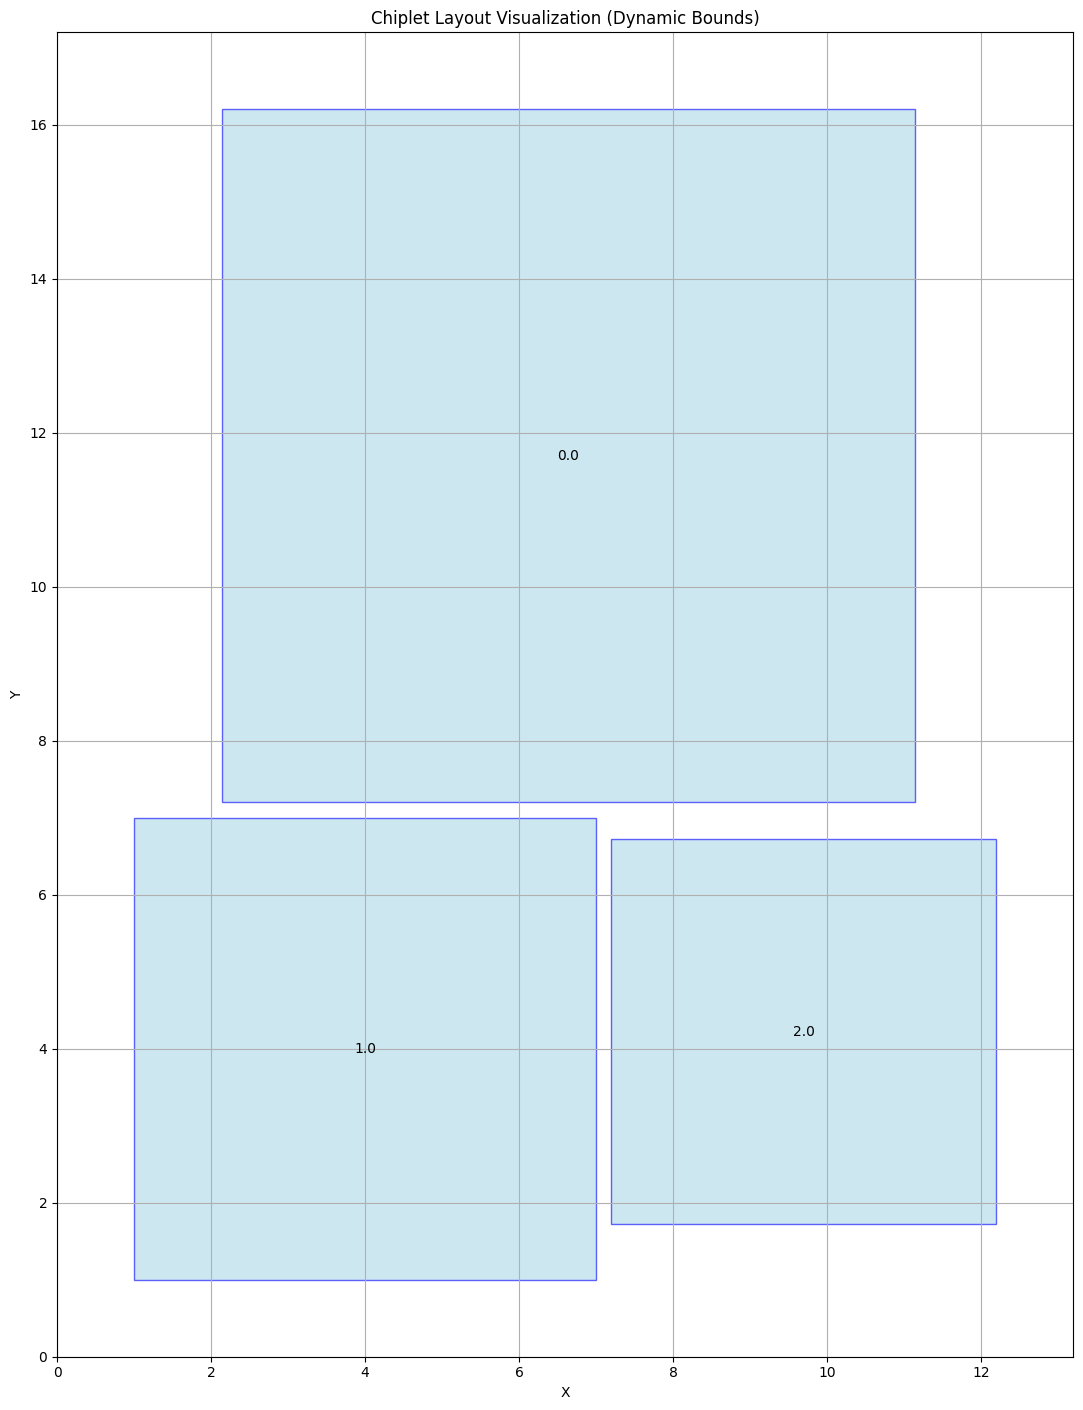

In [18]:
utilities.show_chip_design_cuda(design[0])

In [33]:
a = torch.tensor([[42., 36.,  6.,  6.,  0.],
        [20., 22.,  5.,  5.,  1.],
        [ 1.,  1.,  4.,  4.,  2.]])

a[1][2].item()

5.0